# ---------------------
# Name : Nithish Ra
# Reg : 3122237001033
# ---------------------

# Regression ---> Mobile Phone Price Prediction

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [57]:
data = pd.read_csv("/Mobile-Price-Prediction-cleaned_data.csv")
print("Dataset shape:", data.shape)
data.head()


Dataset shape: (807, 8)


,Ratings,RAM,ROM,Mobile_Size,Primary_Cam,Selfi_Cam,Battery_Power,Price
0,4.3,4.0,128.0,6.00,48,13.0,4000,24999
1,3.4,6.0,64.0,4.50,48,12.0,4000,15999
2,4.3,4.0,4.0,4.50,64,16.0,4000,15000
3,4.4,6.0,64.0,6.40,48,15.0,3800,18999
4,4.5,6.0,128.0,6.18,35,15.0,3800,18999


In [58]:
print("\nTotal nulls per column:")
print(data.isnull().sum())


Total nulls per column:
Ratings          0
RAM              0
ROM              0
Mobile_Size      0
Primary_Cam      0
Selfi_Cam        0
Battery_Power    0
Price            0
dtype: int64


In [59]:
X = data.drop("Price", axis=1).values    # shape (m, d)
y = data["Price"].values.reshape(-1, 1)   # shape (m, 1)

m, d = X.shape
print(f"m={m}, d={d}")

m=807, d=7


In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
m_train = X_train.shape[0]
m_test  = X_test.shape[0]
print("Train shape:", X_train.shape, " Test shape:", X_test.shape)

Train shape: (645, 7)  Test shape: (162, 7)


In [61]:
def add_bias(X):
    return np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)

In [62]:
X_train_bias = add_bias(X_train)
X_test_bias  = add_bias(X_test)

In [63]:
theta_closed = np.linalg.pinv(X_train_bias) @ y_train   # shape (d+1, 1)
y_pred_closed = X_test_bias @ theta_closed

mse_closed = mean_squared_error(y_test, y_pred_closed)
r2_closed = r2_score(y_test, y_pred_closed)
print("\nClosed-form (pinv) -- unscaled: MSE = {:.4f}, R2 = {:.4f}".format(mse_closed, r2_closed))



Closed-form (pinv) -- unscaled: MSE = 239357657.4315, R2 = 0.4332


In [68]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

X_train_bias = add_bias(X_train_scaled)
X_test_bias  = add_bias(X_test_scaled)


In [69]:
def gradient_descent(X, y, lr=0.01, epochs=2000, lam=0.0, tol=1e-8, verbose=False):
    m, n = X.shape   # m samples, n = d+1 params
    theta = np.zeros((n,1))
    prev_loss = np.inf
    losses = []
    for it in range(epochs):
        # predictions
        preds = X @ theta               # (m,1)
        error = preds - y               # (m,1)
        # gradient: (1/m) X^T (X theta - y) + (lambda/m)*[0; theta_1:]
        grad = (1.0/m) * (X.T @ error) + (lam/m) * np.r_[[[0]], theta[1:]]  # do not reg bias
        theta = theta - lr * grad
        loss = (1.0/(2*m)) * np.sum(error**2) + (lam/(2*m))*np.sum(theta[1:]**2)
        losses.append(loss)
        if it % 200 == 0 and verbose:
            print(f"GD iter {it}, loss {loss:.6f}")
        if abs(prev_loss - loss) < tol:
            if verbose:
                print(f"Converged at iter {it}, loss diff {abs(prev_loss-loss):.2e}")
            break
        prev_loss = loss
    return theta, losses

In [70]:
theta_gd, losses_gd = gradient_descent(X_train_bias, y_train, lr=0.01, epochs=10000, lam=0.0, tol=1e-10, verbose=False)
y_pred_gd = X_test_bias @ theta_gd
mse_gd = mean_squared_error(y_test, y_pred_gd)
r2_gd = r2_score(y_test, y_pred_gd)
print("Gradient Descent -- unscaled: MSE = {:.4f}, R2 = {:.4f}".format(mse_gd, r2_gd))

Gradient Descent -- unscaled: MSE = 239357636.4042, R2 = 0.4332


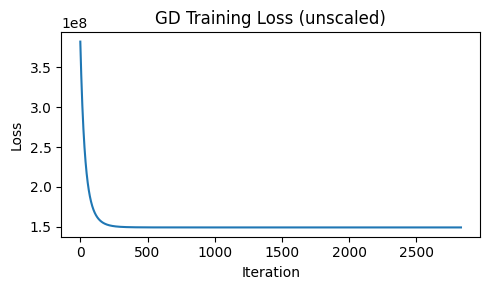

In [71]:
plt.figure(figsize=(5,3))
plt.plot(losses_gd)
plt.title("GD Training Loss (unscaled)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.tight_layout()
plt.show()

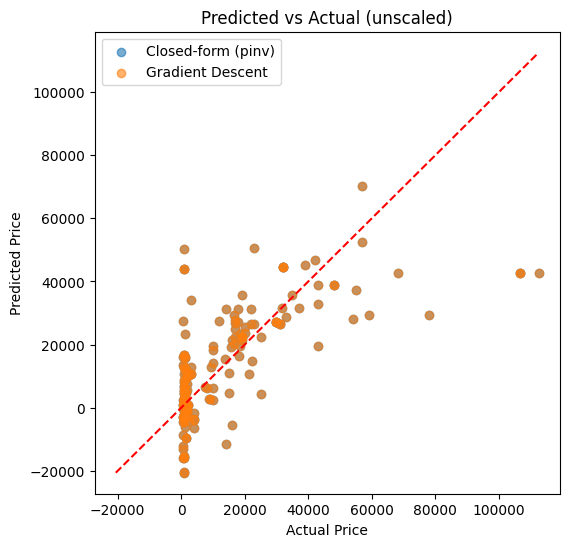

In [72]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_closed, alpha=0.6, label="Closed-form (pinv)")
plt.scatter(y_test, y_pred_gd, alpha=0.6, label="Gradient Descent")
minv = min(y_test.min(), y_pred_closed.min(), y_pred_gd.min())
maxv = max(y_test.max(), y_pred_closed.max(), y_pred_gd.max())
plt.plot([minv, maxv], [minv, maxv], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.legend()
plt.title("Predicted vs Actual (unscaled)")
plt.show()

In [74]:
def ridge_closed_form(X, y, lam=1.0):
    n = X.shape[1]
    D = np.eye(n)
    D[0,0] = 0.0
    A = X.T @ X + lam * D
    theta = np.linalg.solve(A, X.T @ y)   # more stable than inv
    return theta

In [77]:
theta_ridge_unstd = ridge_closed_form(X_train_bias, y_train, lam=1.0)
y_pred_ridge_unstd = X_test_bias @ theta_ridge_unstd
print("\nRidge (lam=1) unstandardized: MSE = {:.4f}, R2 = {:.4f}".format(
    mean_squared_error(y_test, y_pred_ridge_unstd), r2_score(y_test, y_pred_ridge_unstd)))


theta_ridge_gd, _ = gradient_descent(X_train_bias, y_train, lr=0.01, epochs=5000, lam=1.0, verbose=False)
y_pred_ridge_gd = X_test_bias @ theta_ridge_gd
print("Ridge GD (lam=1) unstandardized: MSE = {:.4f}, R2 = {:.4f}".format(
    mean_squared_error(y_test, y_pred_ridge_gd), r2_score(y_test, y_pred_ridge_gd)))


Ridge (lam=1) unstandardized: MSE = 239200533.9648, R2 = 0.4336
Ridge GD (lam=1) unstandardized: MSE = 239200532.5600, R2 = 0.4336


In [78]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

X_train_scaled_bias = add_bias(X_train_scaled)
X_test_scaled_bias  = add_bias(X_test_scaled)

def evaluate_ridge_on_scaled(lam):
    theta = ridge_closed_form(X_train_scaled_bias, y_train, lam=lam)
    preds = X_test_scaled_bias @ theta
    return theta, preds

lams = [0.0, 0.01, 0.1, 1, 10, 100]
mse_vals = []
r2_vals  = []
thetas = {}
for lam in lams:
    theta, preds = evaluate_ridge_on_scaled(lam)
    mse_vals.append(mean_squared_error(y_test, preds))
    r2_vals.append(r2_score(y_test, preds))
    thetas[lam] = theta

print("\nRidge on STANDARDIZED features (summary):")
for lam,mse,r2 in zip(lams, mse_vals, r2_vals):
    print(f"  lambda={lam:>6} : MSE={mse:.4f}, R2={r2:.4f}")


Ridge on STANDARDIZED features (summary):
  lambda=   0.0 : MSE=239357657.4315, R2=0.4332
  lambda=  0.01 : MSE=239356078.1334, R2=0.4332
  lambda=   0.1 : MSE=239341871.8045, R2=0.4333
  lambda=     1 : MSE=239200533.9648, R2=0.4336
  lambda=    10 : MSE=237857213.7589, R2=0.4368
  lambda=   100 : MSE=229594215.3138, R2=0.4563


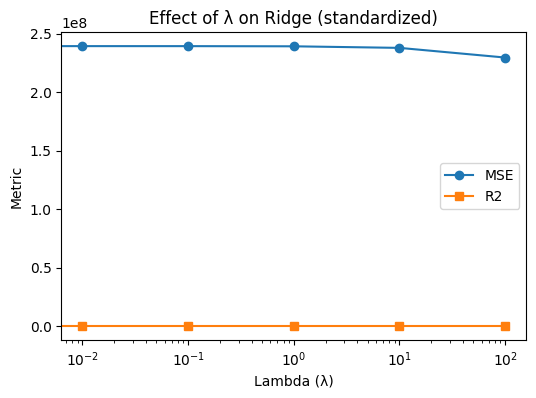

In [79]:
plt.figure(figsize=(6,4))
plt.plot(lams, mse_vals, marker='o', label="MSE")
plt.plot(lams, r2_vals, marker='s', label="R2")
plt.xscale('log')
plt.xlabel("Lambda (λ)")
plt.ylabel("Metric")
plt.title("Effect of λ on Ridge (standardized)")
plt.legend()
plt.show()


Feature importance (standardized coefficients) sorted:
      feature         coef    abs_coef
      Ratings  9692.156085 9692.156085
          RAM  5700.134255 5700.134255
  Primary_Cam -5286.525143 5286.525143
          ROM  3941.592734 3941.592734
Battery_Power  2208.697763 2208.697763
    Selfi_Cam   828.568473  828.568473
  Mobile_Size   465.636685  465.636685


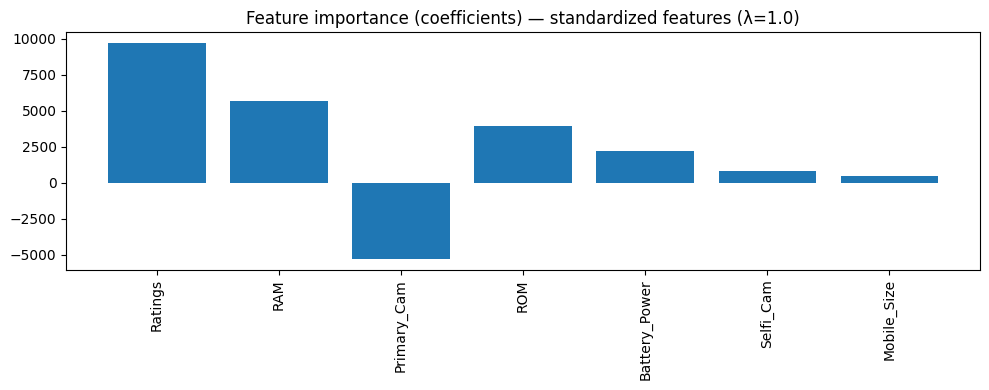

In [81]:
lam_for_importance = 1.0
theta_std = thetas[lam_for_importance].flatten()   # shape (d+1,)
coef_std = theta_std[1:]   # skip bias

# Display numeric sorted importances
importance_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coef_std,
    "abs_coef": np.abs(coef_std)
}).sort_values(by="abs_coef", ascending=False)

print("\nFeature importance (standardized coefficients) sorted:")
print(importance_df.to_string(index=False))

plt.figure(figsize=(10,4))
plt.bar(importance_df['feature'], importance_df['coef'])
plt.xticks(rotation=90)
plt.title(f"Feature importance (coefficients) — standardized features (λ={lam_for_importance})")
plt.tight_layout()
plt.show()

In [82]:
results = []
results.append(("Closed-form (pinv) unscaled", mse_closed, r2_closed))
results.append(("Gradient Descent unscaled", mse_gd, r2_gd))
results.append(("Ridge (lam=1) unstd (closed)", mean_squared_error(y_test,y_pred_ridge_unstd), r2_score(y_test,y_pred_ridge_unstd)))
results.append(("Ridge GD (lam=1) unstd", mean_squared_error(y_test,y_pred_ridge_gd), r2_score(y_test,y_pred_ridge_gd)))
for lam, mse, r2 in zip(lams, mse_vals, r2_vals):
    results.append((f"Ridge standardized lam={lam}", mse, r2))

print("\nExperiment summary (MSE, R2):")
for name,mse,r2 in results:
    print(f"{name:40s}  MSE={mse:.4f}  R2={r2:.4f}")


Experiment summary (MSE, R2):
Closed-form (pinv) unscaled               MSE=239357657.4315  R2=0.4332
Gradient Descent unscaled                 MSE=239357636.4042  R2=0.4332
Ridge (lam=1) unstd (closed)              MSE=239200533.9648  R2=0.4336
Ridge GD (lam=1) unstd                    MSE=239200532.5600  R2=0.4336
Ridge standardized lam=0.0                MSE=239357657.4315  R2=0.4332
Ridge standardized lam=0.01               MSE=239356078.1334  R2=0.4332
Ridge standardized lam=0.1                MSE=239341871.8045  R2=0.4333
Ridge standardized lam=1                  MSE=239200533.9648  R2=0.4336
Ridge standardized lam=10                 MSE=237857213.7589  R2=0.4368
Ridge standardized lam=100                MSE=229594215.3138  R2=0.4563


# -----------------------------------------------------------
# Linear Classification -->  Bank Note Authentication dataset
# -----------------------------------------------------------

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [84]:
data = pd.read_csv("/content/BankNote_Authentication.csv")
print("Dataset shape:", data.shape)
data.head()


Dataset shape: (1372, 5)


,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [85]:
X = data.drop("class", axis=1)
y = data["class"]

# Split into 70% train, 30% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)



Training set size: (960, 4)
Test set size: (412, 4)


In [87]:
clf_no_reg = LogisticRegression(penalty="l2", C=1e10, solver="lbfgs", max_iter=1000)
clf_no_reg.fit(X_train, y_train)

y_pred_train_no_reg = clf_no_reg.predict(X_train)
y_pred_test_no_reg = clf_no_reg.predict(X_test)

print("Training Accuracy (No Reg approx):", accuracy_score(y_train, y_pred_train_no_reg))
print("Test Accuracy (No Reg approx):", accuracy_score(y_test, y_pred_test_no_reg))

Training Accuracy (No Reg approx): 0.9885416666666667
Test Accuracy (No Reg approx): 0.9878640776699029


In [88]:
clf_l2 = LogisticRegression(penalty="l2", C=1.0, solver="lbfgs", max_iter=1000)
clf_l2.fit(X_train, y_train)

y_pred_train_l2 = clf_l2.predict(X_train)
y_pred_test_l2 = clf_l2.predict(X_test)

print("Training Accuracy (L2):", accuracy_score(y_train, y_pred_train_l2))
print("Test Accuracy (L2):", accuracy_score(y_test, y_pred_test_l2))


Training Accuracy (L2): 0.9916666666666667
Test Accuracy (L2): 0.9902912621359223


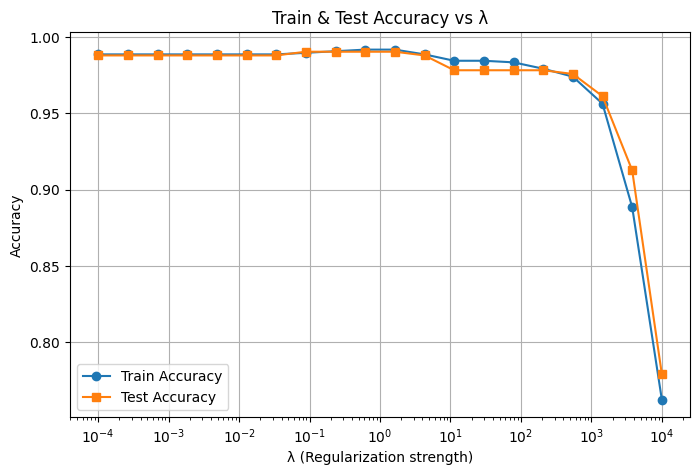

In [89]:
lambdas = np.logspace(-4, 4, 20)  # λ = 1/C
train_acc = []
test_acc = []

for lam in lambdas:
    model = LogisticRegression(penalty="l2", C=1/lam, solver="lbfgs", max_iter=1000)
    model.fit(X_train, y_train)
    train_acc.append(accuracy_score(y_train, model.predict(X_train)))
    test_acc.append(accuracy_score(y_test, model.predict(X_test)))

plt.figure(figsize=(8,5))
plt.semilogx(lambdas, train_acc, label="Train Accuracy", marker="o")
plt.semilogx(lambdas, test_acc, label="Test Accuracy", marker="s")
plt.xlabel("λ (Regularization strength)")
plt.ylabel("Accuracy")
plt.title("Train & Test Accuracy vs λ")
plt.legend()
plt.grid(True)
plt.show()


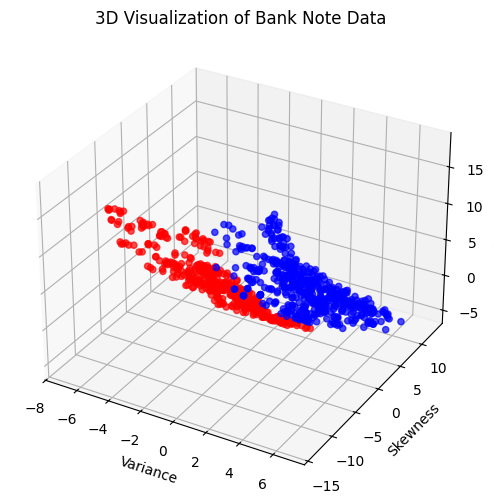

In [90]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# Choose three features
ax.scatter(X_train["variance"], X_train["skewness"], X_train["curtosis"],
           c=y_train, cmap="bwr", alpha=0.7)

ax.set_xlabel("Variance")
ax.set_ylabel("Skewness")
ax.set_zlabel("Curtosis")
ax.set_title("3D Visualization of Bank Note Data")
plt.show()


In [91]:
# Copy dataset
X_outlier = X_train.copy()
y_outlier = y_train.copy()

# Introduce outliers by shifting some points
n_outliers = 20
rng = np.random.RandomState(42)
outlier_indices = rng.choice(len(X_outlier), size=n_outliers, replace=False)

X_outlier.iloc[outlier_indices] = X_outlier.iloc[outlier_indices] + rng.normal(20, 5, X_outlier.shape[1])

print("Introduced", n_outliers, "outliers.")


Introduced 20 outliers.


In [92]:
clf_outlier = LogisticRegression(penalty="l2", C=1.0, solver="lbfgs", max_iter=1000)
clf_outlier.fit(X_outlier, y_outlier)

train_acc_outlier = accuracy_score(y_outlier, clf_outlier.predict(X_outlier))
test_acc_outlier = accuracy_score(y_test, clf_outlier.predict(X_test))

print("Training Accuracy with Outliers:", train_acc_outlier)
print("Test Accuracy with Outliers:", test_acc_outlier)

print("\nImpact: Outliers reduce model generalization. Training accuracy may remain high (model fits noise), but test accuracy usually drops due to distorted decision boundary.")


Training Accuracy with Outliers: 0.928125
Test Accuracy with Outliers: 0.9296116504854369

Impact: Outliers reduce model generalization. Training accuracy may remain high (model fits noise), but test accuracy usually drops due to distorted decision boundary.
